In [1]:
# 通过 bif 文件生成因果数据集 .npy
import numpy as np
import pandas as pd
from pgmpy.readwrite import BIFReader
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianNetwork

/home/wukaiwen/envs/miniconda3/envs/cdllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
data_name = "alarm"
model_path = f"../../models/{data_name}.bif"
n_samples = 1000

In [12]:
# 加载网络模型
reader = BIFReader(model_path)
model = reader.get_model()

# 采样数据
inference = BayesianModelSampling(model)
data = inference.forward_sample(size=n_samples)

# 保存为 .npy 文件
# 可能需要把类别变量转换为数值型
data_numeric = data.apply(lambda x: pd.factorize(x)[0])
np.save(f"../{data_name}_data_n{n_samples}.npy", data_numeric.values)

Generating for node: BP: 100%|██████████| 37/37 [00:00<00:00, 1027.36it/s]


In [13]:
# 可选：保存为 CSV 文件以便查看
data_numeric.to_csv(f"../{data_name}_data_n{n_samples}.csv", index=False)

In [14]:
# 生成答案图的邻接矩阵 .npy 文件
# 注意变量顺序需与数据集一致
columns = list(data.columns)
var_to_idx = {var: i for i, var in enumerate(columns)}
n_vars = len(columns)
adj_matrix = np.zeros((n_vars, n_vars))

for u,v in model.edges():
    if u in var_to_idx and v in var_to_idx:
        u_idx = var_to_idx[u]
        v_idx = var_to_idx[v]
        adj_matrix[u_idx, v_idx] = 1

# save adjacency matrix
np.save(f"../{data_name}_graph.npy", adj_matrix)


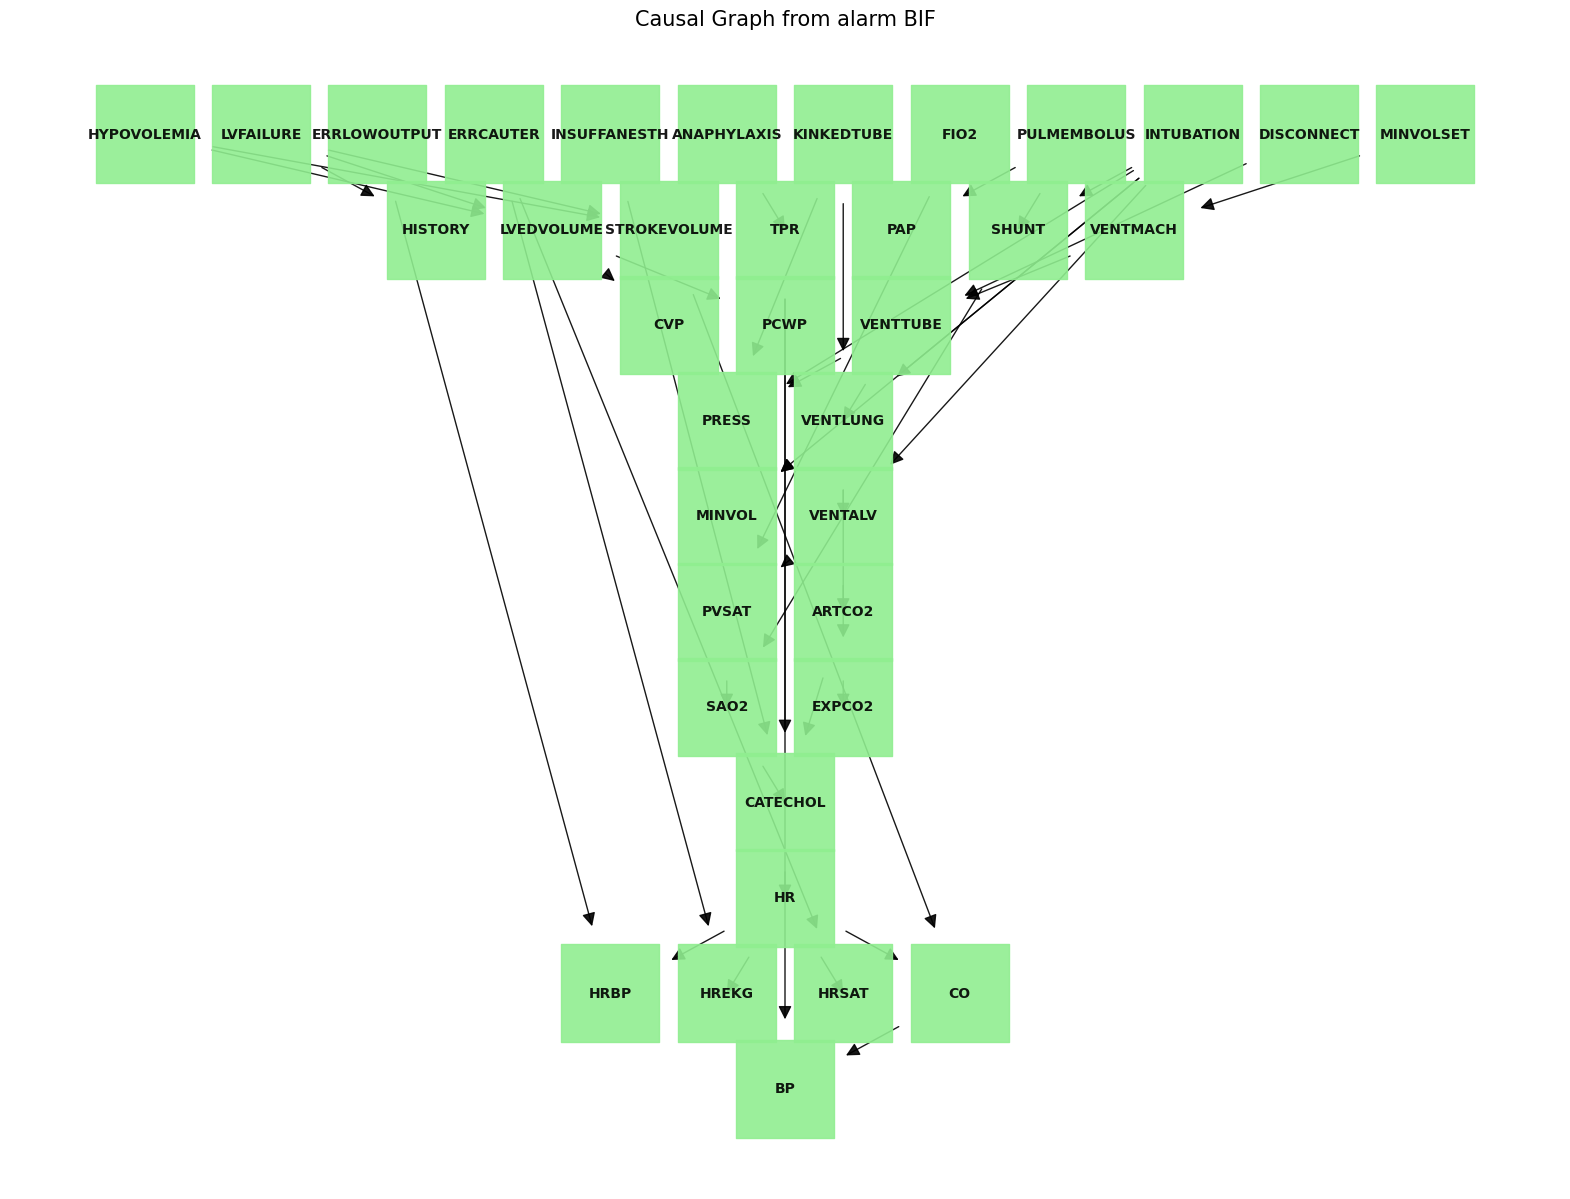

In [18]:
# 可选：用 matplotlib 和 networkx 可视化邻接矩阵
import matplotlib.pyplot as plt
import networkx as nx
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
labels = {i: var for var, i in var_to_idx.items()}
plt.figure(figsize=(20, 15))
plt.axis('off')

try:
    # 1. 获取拓扑分层 (结果是一个列表，例如 [[根节点], [第二层], [第三层]...])
    # 注意：如果图中有环，这一步会报错（因果图理论上不该有环）
    layers = list(nx.topological_generations(G))
    
    pos = {}
    # 2. 手动计算坐标
    for i, layer in enumerate(layers):
        # y轴：层级越高，y越大。这里用 -i 让根节点在最上面
        y = -i 
        
        # x轴：根据该层的节点数量均匀分布
        layer_width = len(layer)
        for j, node in enumerate(layer):
            # 简单的均匀分布计算
            x = j - (layer_width - 1) / 2.0
            pos[node] = (x, y)
            
except nx.NetworkXUnfeasible:
    print("警告：图中存在环，无法进行拓扑分层，回退到 spring_layout")
    pos = nx.spring_layout(G)

# ==========================================
# 绘图部分 (美化样式)
# ==========================================
nx.draw(
    G, pos, 
    labels=labels, 
    with_labels=True, 
    node_color='lightgreen',  # 换个护眼的颜色
    node_size=5000,          # 节点大一点，字才写得下
    node_shape='s',          # 方形节点
    font_size=10, 
    font_weight='bold',
    arrowsize=20,            # 箭头大一点
    edge_color='black',
    alpha=0.9
)

plt.title(f"Causal Graph from {data_name} BIF", fontsize=15)
plt.show()